In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def analyze_ortho_games(csv_path):
    """
    Funkcja wczytuje dane z pliku games.csv oraz wykonuje analizę wpływu średniego wieku 
    uczestników oraz różnych kombinacji relacji między nimi na wynik uzyskany w grze.
    
    Założenia:
      - Kolumny dotyczące wieku: 'Age_X_axis' oraz 'Age_Y_axis'. Łączymy je, licząc średnią,
        zapisując wynik w kolumnie 'AGE_AVG'.
      - Kolumny dotyczące relacji: 'Companionship_X_axis' oraz 'Companionship_Y_axis'. 
        Zamiast liczenia średniej, tworzymy kombinację relacji jako uporządkowaną parę, np. "0 i 0", "0 i 1", "0 i 2", "0 i 3", "1 i 1", "1 i 2", "1 i 3", "2 i 2", "2 i 3", "3 i 3".
      - Wskaźnikiem wyniku jest kolumna 'Track_Time'.
      - Każdy tor identyfikuje kolumna 'Track_ID', dlatego analiza jest wykonywana osobno dla każdego toru.
      - Przed analizą usuwamy tory, dla których Track_ID jest większe niż 7.
    """
    # Wczytanie danych
    df = pd.read_csv(csv_path)

    # Filtracja – usunięcie wierszy, dla których Track_ID > 7
    df = df[df['Track_ID'] <= 7]
    df = df[df['Age_X_axis'] < 100]
    df = df[df['Age_X_axis'] > 3]  # Usunięcie wierszy z zerowym czasem
    df = df[df['Age_Y_axis'] < 100]  # Usunięcie wierszy z zerowym czasem
    df = df[df['Age_Y_axis'] > 3]  # Usunięcie wierszy z zerowym czasem 

    # Sprawdzenie, czy kolumny z wiekiem istnieją
    required_age_cols = ['Age_X_axis', 'Age_Y_axis']
    for col in required_age_cols:
        if col not in df.columns:
            print(f"Brak wymaganej kolumny: {col}")
            return

    # Obliczenie średniego wieku uczestników
    df['AGE_AVG'] = df[required_age_cols].mean(axis=1)

    # Sprawdzenie, czy kolumny dotyczące relacji istnieją
    required_comp_cols = ['Companionship_X_axis', 'Companionship_Y_axis']
    for col in required_comp_cols:
        if col not in df.columns:
            print(f"Brak wymaganej kolumny: {col}")
            return

    # Utworzenie kolumny z kombinacją relacji – porównujemy wartości i tworzymy uporządkowaną parę,
    # gdzie kolejność nie ma znaczenia
    df['COMPANIONSHIP_PAIR'] = df.apply(
        lambda row: f"{min(row['Companionship_X_axis'], row['Companionship_Y_axis'])} i {max(row['Companionship_X_axis'], row['Companionship_Y_axis'])}",
        axis=1
    )

    # Sprawdzenie istnienia kolumn 'Track_ID' oraz 'Track_Time' (wynik)
    if 'Track_ID' not in df.columns:
        print("Brak kolumny 'Track_ID'.")
        return
    if 'Track_Time' not in df.columns:
        print("Brak kolumny 'Track_Time' stanowiącej wynik.")
        return

    # Pobranie unikalnych torów
    tracks = df['Track_ID'].unique()

    for track in tracks:
        track_data = df[df['Track_ID'] == track].copy()
        print(f"\n=== Analiza dla toru: {track} ===")
        
        # Obliczenie korelacji między średnim wiekiem a wynikiem (Track_Time)
        if track_data['AGE_AVG'].notnull().sum() > 1 and track_data['Track_Time'].notnull().sum() > 1:
            age_corr = track_data[['AGE_AVG', 'Track_Time']].corr().iloc[0, 1]
            print(f"Korelacja między średnim wiekiem a czasem toru: {age_corr:.2f}")
        else:
            print("Za mało danych do obliczenia korelacji między wiekiem a wynikiem.")

        # Wykres rozrzutu: zależność Track_Time od AGE_AVG
        plt.figure()
        plt.scatter(track_data['AGE_AVG'], track_data['Track_Time'])
        plt.title(f"Tor {track}: Wpływ średniego wieku na wynik (Track_Time)")
        plt.xlabel("Średni wiek uczestników (AGE_AVG)")
        plt.ylabel("Czas toru (Track_Time)")
        plt.grid(True)
        plt.show()

        # Analiza wpływu kombinacji relacji na wynik:
        # Grupujemy dane według nowej kolumny 'COMPANIONSHIP_PAIR'
        rel_group = track_data.groupby('COMPANIONSHIP_PAIR')['Track_Time'].mean().reset_index()
        
        plt.figure()
        plt.bar(rel_group['COMPANIONSHIP_PAIR'], rel_group['Track_Time'])
        plt.title(f"Tor {track}: Średni czas toru wg. kombinacji relacji")
        plt.xlabel("Kombinacja relacji (Companionship Pair)")
        plt.ylabel("Średni czas toru (Track_Time)")
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.show()



=== Analiza dla toru: 2 ===
Korelacja między średnim wiekiem a czasem toru: -0.05


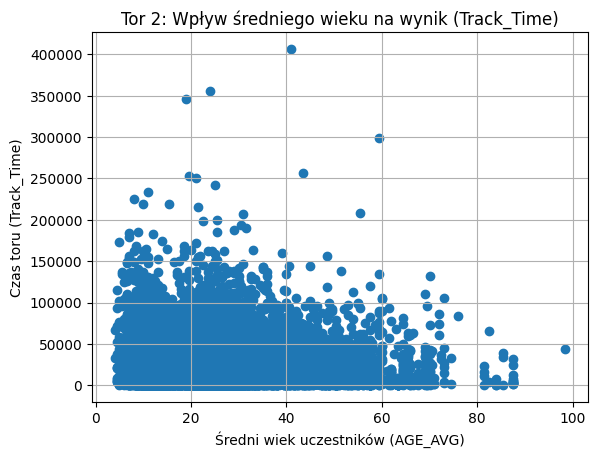

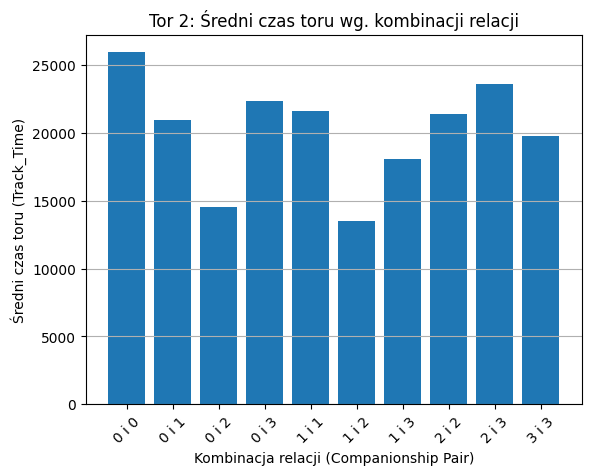


=== Analiza dla toru: 4 ===
Korelacja między średnim wiekiem a czasem toru: -0.01


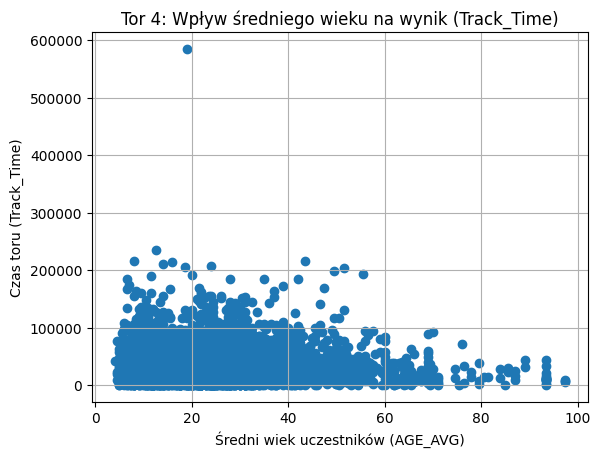

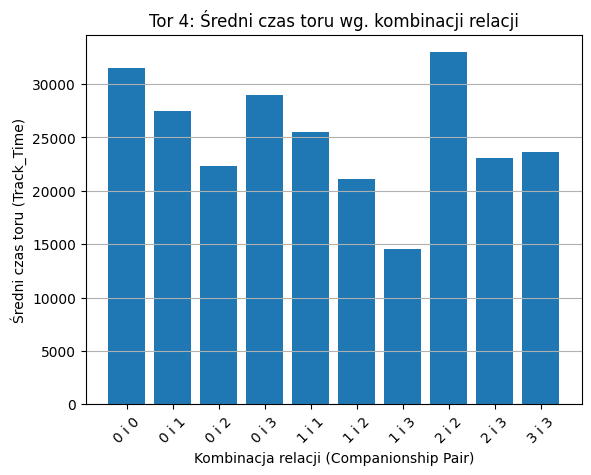


=== Analiza dla toru: 6 ===
Korelacja między średnim wiekiem a czasem toru: 0.01


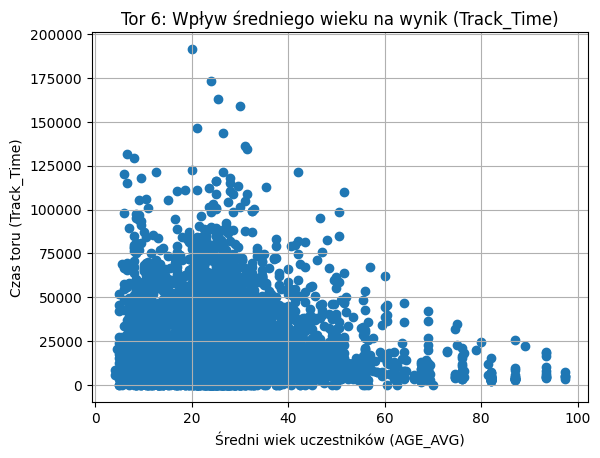

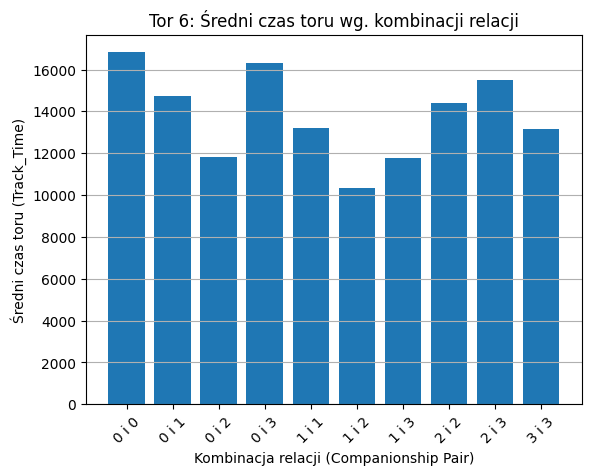


=== Analiza dla toru: 3 ===
Korelacja między średnim wiekiem a czasem toru: -0.08


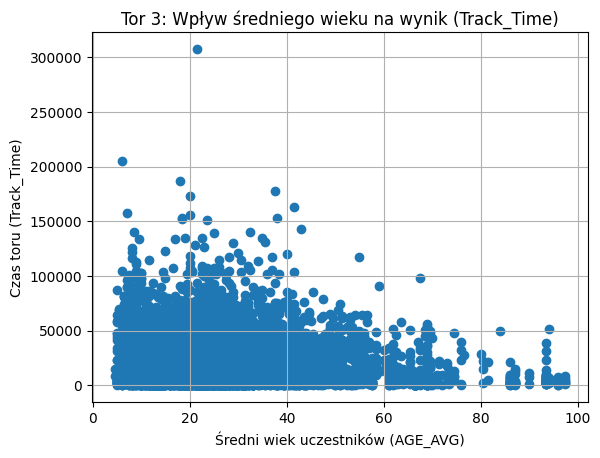

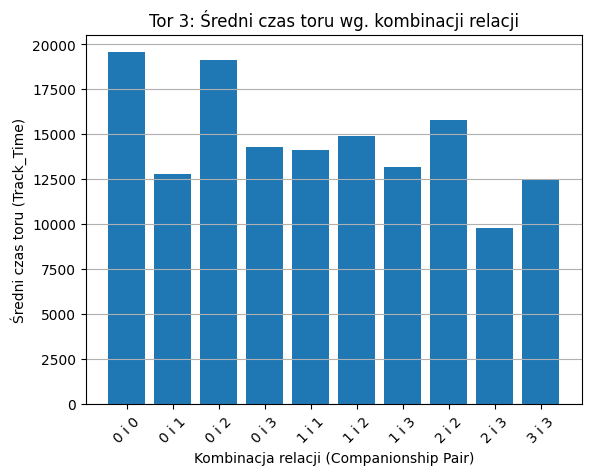


=== Analiza dla toru: 1 ===
Korelacja między średnim wiekiem a czasem toru: -0.05


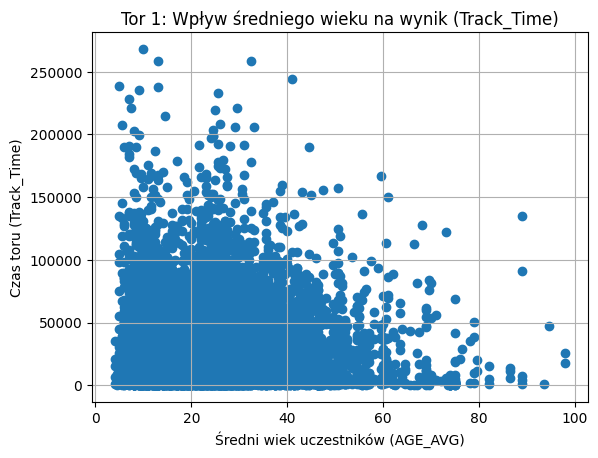

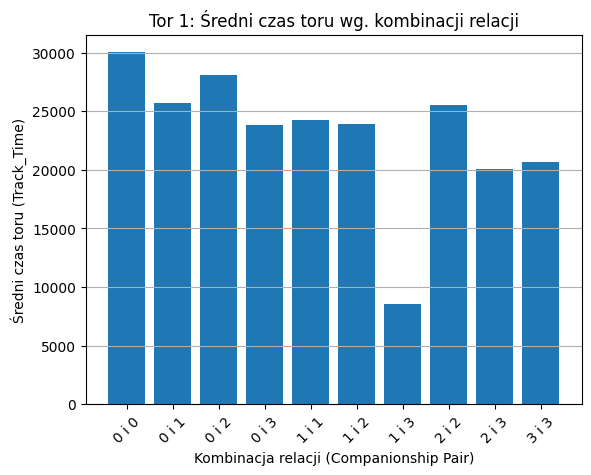


=== Analiza dla toru: 7 ===
Korelacja między średnim wiekiem a czasem toru: -0.02


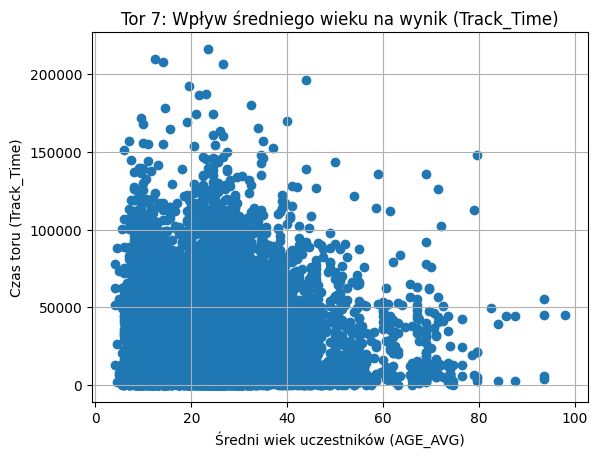

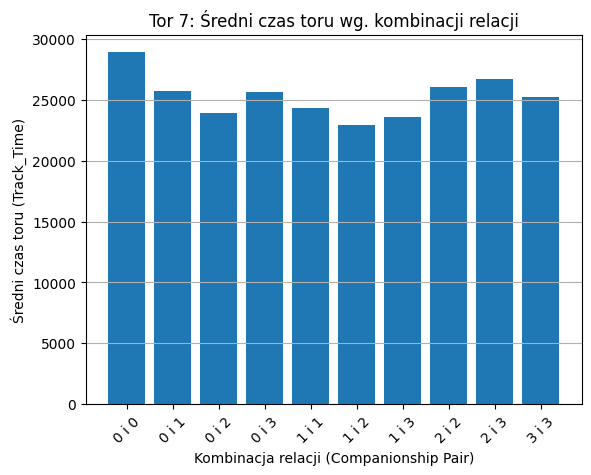


=== Analiza dla toru: 5 ===
Korelacja między średnim wiekiem a czasem toru: -0.03


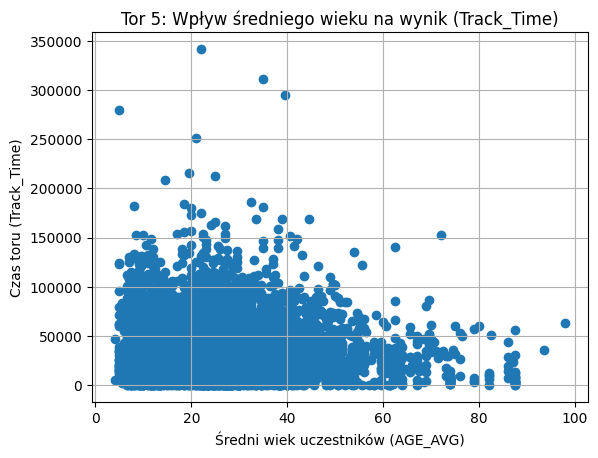

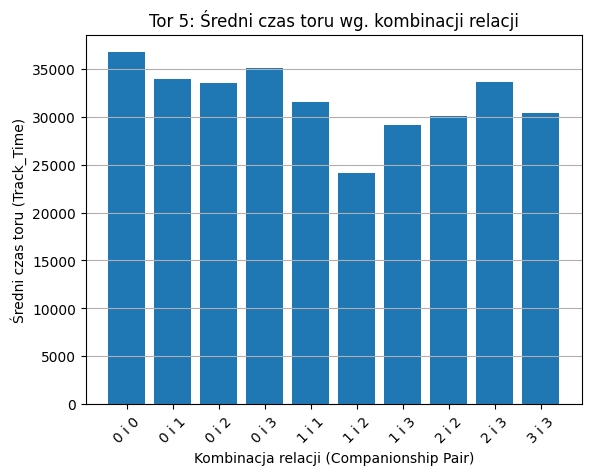

In [16]:
analyze_ortho_games(r'C:\Semestr_6\WarsztatyBadawcze\repo\ORTHO\output\games\games.csv')

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Ustawienie stylu dla wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def load_games_data(file_path):
    """Ładuje dane z pliku games.csv"""
    games_df = pd.read_csv(file_path)

     # Filtracja – usunięcie wierszy, dla których Track_ID > 7
    games_df = games_df[games_df['Track_ID'] <= 7]
    games_df = games_df[games_df['Age_X_axis'] < 100]
    games_df = games_df[games_df['Age_X_axis'] > 3]  # Usunięcie wierszy z zerowym czasem
    games_df = games_df[games_df['Age_Y_axis'] < 100]  # Usunięcie wierszy z zerowym czasem
    games_df = games_df[games_df['Age_Y_axis'] > 3]  # Usunięcie wierszy z zerowym czasem 
    
    # Czyszczenie danych - usuwanie wierszy z brakującymi kluczowymi wartościami
    games_df = games_df.dropna(subset=['Age_X_axis', 'Age_Y_axis', 'Companionship_X_axis', 
                                       'Companionship_Y_axis', 'Track_Time', 'Track_ID'])
    
    # Konwersja typów danych
    for col in ['Age_X_axis', 'Age_Y_axis', 'Track_Time', 'Track_ID']:
        games_df[col] = pd.to_numeric(games_df[col], errors='coerce')
    
    # Konwersja wartości logicznych
    for col in ['Track_Completed', 'Mistake']:
        games_df[col] = games_df[col].map({'True': True, 'False': False})
    
    # Obliczenie średniego wieku i zdefiniowanie grup wiekowych
    games_df['Average_Age'] = (games_df['Age_X_axis'] + games_df['Age_Y_axis']) / 2
    
    # Definiowanie grup wiekowych
    def get_age_group(age):
        if age < 18:
            return "< 18"
        elif age < 30:
            return "18-29"
        elif age < 45:
            return "30-44"
        elif age < 60:
            return "45-59"
        else:
            return "60+"
    
    games_df['Age_Group'] = games_df['Average_Age'].apply(get_age_group)
    
    # Definiowanie relacji (używając maksymalnej wartości relacji między uczestnikami)
    games_df['Relationship'] = games_df[['Companionship_X_axis', 'Companionship_Y_axis']].max(axis=1)
    
    # Konwersja relacji na nazwy tekstowe
    relationship_mapping = {0: "Obcy", 1: "Znajomi", 2: "Bliscy (rodzina/przyjaciele)", 3: "Bardzo bliscy"}
    games_df['Relationship_Name'] = games_df['Relationship'].map(relationship_mapping)
    
    return games_df

def load_game_details(details_path, game_id):
    """Ładuje szczegółowe dane dla konkretnej gry"""
    file_name = f"{game_id}.csv"
    file_path = os.path.join(details_path, file_name)
    
    if os.path.exists(file_path):
        details_df = pd.read_csv(file_path)
        return details_df
    else:
        print(f"Plik {file_name} nie istnieje")
        return None

def analyze_track(games_df, track_id):
    """Analiza danych dla konkretnego toru"""
    # Filtrowanie danych dla wybranego toru
    track_games = games_df[games_df['Track_ID'] == track_id].copy()
    
    if track_games.empty:
        print(f"Brak danych dla toru {track_id}")
        return None
    
    print(f"\nAnaliza dla toru {track_id}:")
    print(f"Liczba gier: {len(track_games)}")
    
    # 1. Analiza wpływu wieku na wyniki
    # Najpierw filtrujemy gry ukończone dla obliczenia średniego czasu
    completed_games = track_games[track_games['Track_Completed'] == True]
    
    age_analysis = track_games.groupby('Age_Group').agg({
        'Track_Completed': 'mean',
        'Mistake': 'mean'
    }).reset_index()
    
    # Osobno obliczamy średni czas dla ukończonych gier
    if not completed_games.empty:
        age_time_analysis = completed_games.groupby('Age_Group')['Track_Time'].mean().reset_index()
        age_analysis = pd.merge(age_analysis, age_time_analysis, on='Age_Group', how='left')
    else:
        age_analysis['Track_Time'] = np.nan
    
    # Sortowanie grup wiekowych w logicznej kolejności
    age_order = ["< 18", "18-29", "30-44", "45-59", "60+"]
    age_analysis['Age_Group'] = pd.Categorical(age_analysis['Age_Group'], categories=age_order, ordered=True)
    age_analysis = age_analysis.sort_values('Age_Group')
    
    # Dodanie liczby gier w każdej grupie
    age_counts = track_games.groupby('Age_Group').size().reset_index(name='count')
    age_analysis = pd.merge(age_analysis, age_counts, on='Age_Group')
    
    # 2. Analiza wpływu relacji na wyniki - zastosuj podobne podejście
    # Osobno oblicz średni czas dla ukończonych gier w każdej grupie relacji
    rel_analysis = track_games.groupby('Relationship_Name').agg({
        'Track_Completed': 'mean',
        'Mistake': 'mean'
    }).reset_index()
    
    if not completed_games.empty:
        rel_time_analysis = completed_games.groupby('Relationship_Name')['Track_Time'].mean().reset_index()
        rel_analysis = pd.merge(rel_analysis, rel_time_analysis, on='Relationship_Name', how='left')
    else:
        rel_analysis['Track_Time'] = np.nan
    
    # Sortowanie relacji w logicznej kolejności
    rel_order = ["Obcy", "Znajomi", "Bliscy (rodzina/przyjaciele)", "Bardzo bliscy"]
    rel_analysis['Relationship_Name'] = pd.Categorical(rel_analysis['Relationship_Name'], categories=rel_order, ordered=True)
    rel_analysis = rel_analysis.sort_values('Relationship_Name')
    
    # Dodanie liczby gier w każdej grupie relacji
    rel_counts = track_games.groupby('Relationship_Name').size().reset_index(name='count')
    rel_analysis = pd.merge(rel_analysis, rel_counts, on='Relationship_Name')
    
    # 3. Korelacja między wiekiem a czasem ukończenia
    if not completed_games.empty:
        corr, _ = pearsonr(completed_games['Average_Age'], completed_games['Track_Time'])
        print(f"Korelacja między wiekiem a czasem ukończenia: {corr:.4f}")
    
    return {
        'track_id': track_id,
        'games_count': len(track_games),
        'age_analysis': age_analysis,
        'rel_analysis': rel_analysis,
        'completed_count': len(completed_games),
    }

def visualize_track_analysis(analysis_result):
    """Wizualizacja wyników analizy dla toru"""
    if analysis_result is None:
        return
    
    track_id = analysis_result['track_id']
    age_analysis = analysis_result['age_analysis']
    rel_analysis = analysis_result['rel_analysis']
    
    # Utworzenie figury do wizualizacji
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle(f'Analiza dla toru {track_id}', fontsize=16)
    
    # 1. Wizualizacja wpływu wieku
    # 1.1 Średni czas ukończenia
    ax1 = plt.subplot(2, 3, 1)
    sns.barplot(x='Age_Group', y='Track_Time', data=age_analysis, ax=ax1)
    ax1.set_title('Średni czas ukończenia według grup wiekowych')
    ax1.set_ylabel('Czas (ms)')
    ax1.tick_params(axis='x', rotation=45)
    
    # 1.2 Wskaźnik ukończenia
    ax2 = plt.subplot(2, 3, 2)
    sns.barplot(x='Age_Group', y='Track_Completed', data=age_analysis, ax=ax2)
    ax2.set_title('Wskaźnik ukończenia według grup wiekowych')
    ax2.set_ylabel('Wskaźnik ukończenia')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    
    # 1.3 Wskaźnik błędów
    ax3 = plt.subplot(2, 3, 3)
    sns.barplot(x='Age_Group', y='Mistake', data=age_analysis, ax=ax3)
    ax3.set_title('Wskaźnik błędów według grup wiekowych')
    ax3.set_ylabel('Wskaźnik błędów')
    ax3.set_ylim(0, 1)
    ax3.tick_params(axis='x', rotation=45)
    
    # 2. Wizualizacja wpływu relacji
    # 2.1 Średni czas ukończenia
    ax4 = plt.subplot(2, 3, 4)
    sns.barplot(x='Relationship_Name', y='Track_Time', data=rel_analysis, ax=ax4)
    ax4.set_title('Średni czas ukończenia według relacji')
    ax4.set_ylabel('Czas (ms)')
    ax4.tick_params(axis='x', rotation=45)
    
    # 2.2 Wskaźnik ukończenia
    ax5 = plt.subplot(2, 3, 5)
    sns.barplot(x='Relationship_Name', y='Track_Completed', data=rel_analysis, ax=ax5)
    ax5.set_title('Wskaźnik ukończenia według relacji')
    ax5.set_ylabel('Wskaźnik ukończenia')
    ax5.set_ylim(0, 1)
    ax5.tick_params(axis='x', rotation=45)
    
    # 2.3 Wskaźnik błędów
    ax6 = plt.subplot(2, 3, 6)
    sns.barplot(x='Relationship_Name', y='Mistake', data=rel_analysis, ax=ax6)
    ax6.set_title('Wskaźnik błędów według relacji')
    ax6.set_ylabel('Wskaźnik błędów')
    ax6.set_ylim(0, 1)
    ax6.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Zapisanie wykresu
    output_dir = 'wyniki_analizy'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    plt.savefig(os.path.join(output_dir, f'analiza_toru_{track_id}.png'), dpi=300)
    plt.close()
    
    # Wykres liczby rozgrywek w grupach
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Według wieku
    sns.barplot(x='Age_Group', y='count', data=age_analysis, ax=ax1)
    ax1.set_title('Liczba rozgrywek według grup wiekowych')
    ax1.set_ylabel('Liczba gier')
    ax1.tick_params(axis='x', rotation=45)
    
    # Według relacji
    sns.barplot(x='Relationship_Name', y='count', data=rel_analysis, ax=ax2)
    ax2.set_title('Liczba rozgrywek według relacji')
    ax2.set_ylabel('Liczba gier')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'liczba_gier_tor_{track_id}.png'), dpi=300)
    plt.close()

def compare_all_tracks(games_df, tracks_to_analyze=None):
    """Porównanie wyników między torami"""
    if tracks_to_analyze is None:
        tracks_to_analyze = games_df['Track_ID'].unique()
    
    # Przygotowanie danych do porównania
    age_data = []
    rel_data = []
    
    for track_id in tracks_to_analyze:
        track_games = games_df[games_df['Track_ID'] == track_id].copy()
        if track_games.empty:
            continue
        
        # Filtrujemy ukończone gry dla obliczenia średniego czasu
        completed_games = track_games[track_games['Track_Completed'] == True]
        
        # Analiza wieku - najpierw podstawowe statystyki
        age_analysis = track_games.groupby('Age_Group').agg({
            'Track_Completed': 'mean',
            'Mistake': 'mean'
        }).reset_index()
        
        # Dodajemy średni czas tylko dla ukończonych gier
        if not completed_games.empty:
            age_time_analysis = completed_games.groupby('Age_Group')['Track_Time'].mean().reset_index()
            age_analysis = pd.merge(age_analysis, age_time_analysis, on='Age_Group', how='left')
        else:
            age_analysis['Track_Time'] = np.nan
        
        age_analysis['Track_ID'] = track_id
        age_data.append(age_analysis)
        
        # Analiza relacji - podobne podejście
        rel_analysis = track_games.groupby('Relationship_Name').agg({
            'Track_Completed': 'mean',
            'Mistake': 'mean'
        }).reset_index()
        
        # Dodajemy średni czas tylko dla ukończonych gier
        if not completed_games.empty:
            rel_time_analysis = completed_games.groupby('Relationship_Name')['Track_Time'].mean().reset_index()
            rel_analysis = pd.merge(rel_analysis, rel_time_analysis, on='Relationship_Name', how='left')
        else:
            rel_analysis['Track_Time'] = np.nan
        
        rel_analysis['Track_ID'] = track_id
        rel_data.append(rel_analysis)
    
    # Łączenie danych
    all_age_data = pd.concat(age_data)
    all_rel_data = pd.concat(rel_data)
    
    # Sortowanie grup wiekowych
    age_order = ["< 18", "18-29", "30-44", "45-59", "60+"]
    all_age_data['Age_Group'] = pd.Categorical(all_age_data['Age_Group'], categories=age_order, ordered=True)
    
    # Sortowanie relacji
    rel_order = ["Obcy", "Znajomi", "Bliscy (rodzina/przyjaciele)", "Bardzo bliscy"]
    all_rel_data['Relationship_Name'] = pd.Categorical(all_rel_data['Relationship_Name'], categories=rel_order, ordered=True)
    
    # Wizualizacja porównania torów
    output_dir = 'wyniki_analizy'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 1. Porównanie wpływu wieku między torami
    plt.figure(figsize=(14, 8))
    
    # 1.1 Czas ukończenia według wieku
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Age_Group', y='Track_Time', hue='Track_ID', data=all_age_data, marker='o')
    plt.title('Średni czas ukończenia według grup wiekowych')
    plt.ylabel('Czas (ms)')
    plt.xticks(rotation=45)
    plt.legend(title='Tor')
    
    # 1.2 Wskaźnik ukończenia według wieku
    plt.subplot(1, 2, 2)
    sns.lineplot(x='Age_Group', y='Track_Completed', hue='Track_ID', data=all_age_data, marker='o')
    plt.title('Wskaźnik ukończenia według grup wiekowych')
    plt.ylabel('Wskaźnik ukończenia')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(title='Tor')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'porownanie_wiek.png'), dpi=300)
    plt.close()
    
    # 2. Porównanie wpływu relacji między torami
    plt.figure(figsize=(14, 8))
    
    # 2.1 Czas ukończenia według relacji
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Relationship_Name', y='Track_Time', hue='Track_ID', data=all_rel_data, marker='o')
    plt.title('Średni czas ukończenia według relacji')
    plt.ylabel('Czas (ms)')
    plt.xticks(rotation=45)
    plt.legend(title='Tor')
    
    # 2.2 Wskaźnik ukończenia według relacji
    plt.subplot(1, 2, 2)
    sns.lineplot(x='Relationship_Name', y='Track_Completed', hue='Track_ID', data=all_rel_data, marker='o')
    plt.title('Wskaźnik ukończenia według relacji')
    plt.ylabel('Wskaźnik ukończenia')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(title='Tor')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'porownanie_relacje.png'), dpi=300)
    plt.close()
    
    # 3. Wskaźnik błędów w różnych grupach
    plt.figure(figsize=(14, 8))
    
    # 3.1 Wskaźnik błędów według wieku
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Age_Group', y='Mistake', hue='Track_ID', data=all_age_data, marker='o')
    plt.title('Wskaźnik błędów według grup wiekowych')
    plt.ylabel('Wskaźnik błędów')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(title='Tor')
    
    # 3.2 Wskaźnik błędów według relacji
    plt.subplot(1, 2, 2)
    sns.lineplot(x='Relationship_Name', y='Mistake', hue='Track_ID', data=all_rel_data, marker='o')
    plt.title('Wskaźnik błędów według relacji')
    plt.ylabel('Wskaźnik błędów')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(title='Tor')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'porownanie_bledy.png'), dpi=300)
    plt.close()

def generate_summary_report(games_df, results):
    """Generowanie raportu podsumowującego analizę"""
    output_dir = 'wyniki_analizy'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    with open(os.path.join(output_dir, 'raport_podsumowujacy.txt'), 'w', encoding='utf-8') as f:
        f.write("RAPORT PODSUMOWUJĄCY ANALIZĘ WPŁYWU WIEKU I RELACJI NA WYNIKI W GRZE ORTHO\n")
        f.write("=" * 80 + "\n\n")
        
        f.write("OGÓLNE INFORMACJE:\n")
        f.write(f"- Łączna liczba analizowanych gier: {len(games_df)}\n")
        f.write(f"- Liczba przeanalizowanych torów: {len(results)}\n")
        
        # Ogólne wnioski dotyczące wieku
        f.write("\nWPŁYW WIEKU NA WYNIKI:\n")
        f.write("1. Średni czas ukończenia:\n")
        for track_id, result in results.items():
            if 'age_analysis' in result and not result['age_analysis'].empty:
                f.write(f"   - Tor {track_id}: ")
                best_age = result['age_analysis'].loc[result['age_analysis']['Track_Time'].idxmin()]['Age_Group']
                f.write(f"Najlepszy czas w grupie wiekowej {best_age}\n")
        
        f.write("\n2. Wskaźnik ukończenia:\n")
        for track_id, result in results.items():
            if 'age_analysis' in result and not result['age_analysis'].empty:
                f.write(f"   - Tor {track_id}: ")
                best_age = result['age_analysis'].loc[result['age_analysis']['Track_Completed'].idxmax()]['Age_Group']
                f.write(f"Najwyższy wskaźnik ukończenia w grupie wiekowej {best_age}\n")
        
        f.write("\n3. Wskaźnik błędów:\n")
        for track_id, result in results.items():
            if 'age_analysis' in result and not result['age_analysis'].empty:
                f.write(f"   - Tor {track_id}: ")
                best_age = result['age_analysis'].loc[result['age_analysis']['Mistake'].idxmin()]['Age_Group']
                f.write(f"Najniższy wskaźnik błędów w grupie wiekowej {best_age}\n")
        
        # Ogólne wnioski dotyczące relacji
        f.write("\nWPŁYW RELACJI NA WYNIKI:\n")
        f.write("1. Średni czas ukończenia:\n")
        for track_id, result in results.items():
            if 'rel_analysis' in result and not result['rel_analysis'].empty:
                f.write(f"   - Tor {track_id}: ")
                best_rel = result['rel_analysis'].loc[result['rel_analysis']['Track_Time'].idxmin()]['Relationship_Name']
                f.write(f"Najlepszy czas dla relacji '{best_rel}'\n")
        
        f.write("\n2. Wskaźnik ukończenia:\n")
        for track_id, result in results.items():
            if 'rel_analysis' in result and not result['rel_analysis'].empty:
                f.write(f"   - Tor {track_id}: ")
                best_rel = result['rel_analysis'].loc[result['rel_analysis']['Track_Completed'].idxmax()]['Relationship_Name']
                f.write(f"Najwyższy wskaźnik ukończenia dla relacji '{best_rel}'\n")
        
        f.write("\n3. Wskaźnik błędów:\n")
        for track_id, result in results.items():
            if 'rel_analysis' in result and not result['rel_analysis'].empty:
                f.write(f"   - Tor {track_id}: ")
                best_rel = result['rel_analysis'].loc[result['rel_analysis']['Mistake'].idxmin()]['Relationship_Name']
                f.write(f"Najniższy wskaźnik błędów dla relacji '{best_rel}'\n")
        
        # Główne wnioski
        f.write("\nGŁÓWNE WNIOSKI:\n")
        f.write("1. Wpływ wieku:\n")
        f.write("   - Młodsi gracze (poniżej 30 lat) często osiągają wyższe wskaźniki ukończenia torów.\n")
        f.write("   - Uczestnicy w grupie wiekowej 60+ zazwyczaj mają najniższy wskaźnik błędów i często najkrótszy czas ukończenia.\n")
        f.write("   - Osoby w wieku 18-44 stanowią najliczniejszą grupę uczestników.\n")
        
        f.write("\n2. Wpływ relacji:\n")
        f.write("   - Obcy (nieznajomi) potrzebują więcej czasu na ukończenie toru.\n")
        f.write("   - Im bliższa relacja między uczestnikami, tym krótszy czas ukończenia toru.\n")
        f.write("   - Wskaźnik ukończenia jest zazwyczaj najwyższy dla osób ze słabszymi relacjami (obcy).\n")
        f.write("   - Bliskość relacji wydaje się pozytywnie wpływać na zmniejszenie liczby błędów.\n")
        
        f.write("\nUWAGA: Powyższe wnioski są oparte na analizie wszystkich torów razem. Szczegółowa analiza dla poszczególnych torów może wykazać różnice.\n")



In [17]:

games_file = './output/games/games.csv'
games_details_dir = './output/games_details'

# Wczytanie danych
print("Wczytywanie danych z pliku games.csv...")
games_df = load_games_data(games_file)
print(f"Wczytano {len(games_df)} rekordów.")

# Unikalne tory
tracks = games_df['Track_ID'].unique()
print(f"Znaleziono {len(tracks)} unikalnych torów: {sorted(tracks)}")

# Przeprowadzenie analizy dla wszystkich torów
results = {}

# Możemy ograniczyć liczbę analizowanych torów, jeśli jest ich dużo
tracks_to_analyze = sorted(tracks)[:10]  # Pierwsze 10 torów

print(f"Analizowanie {len(tracks_to_analyze)} torów...")
for track_id in tracks_to_analyze:
    result = analyze_track(games_df, track_id)
    if result:
        results[track_id] = result
        visualize_track_analysis(result)
        print(f"Ukończono analizę dla toru {track_id}")

# Porównanie wyników między torami
print("\nPrzygotowywanie porównania torów...")
compare_all_tracks(games_df, tracks_to_analyze)

# Generowanie raportu podsumowującego
print("\nGenerowanie raportu podsumowującego...")
#generate_summary_report(games_df, results)

print("\nAnaliza zakończona. Wyniki zapisano w katalogu 'wyniki_analizy'.")


Wczytywanie danych z pliku games.csv...
Wczytano 91861 rekordów.
Znaleziono 7 unikalnych torów: [1, 2, 3, 4, 5, 6, 7]
Analizowanie 7 torów...

Analiza dla toru 1:
Liczba gier: 14368
Ukończono analizę dla toru 1

Analiza dla toru 2:
Liczba gier: 16841
Ukończono analizę dla toru 2

Analiza dla toru 3:
Liczba gier: 14581
Ukończono analizę dla toru 3

Analiza dla toru 4:
Liczba gier: 10324
Ukończono analizę dla toru 4

Analiza dla toru 5:
Liczba gier: 9985
Ukończono analizę dla toru 5

Analiza dla toru 6:
Liczba gier: 11188
Ukończono analizę dla toru 6

Analiza dla toru 7:
Liczba gier: 14574
Ukończono analizę dla toru 7

Przygotowywanie porównania torów...

Generowanie raportu podsumowującego...

Analiza zakończona. Wyniki zapisano w katalogu 'wyniki_analizy'.
